<a href="https://colab.research.google.com/github/emyesme/ExpectationMaximizationAlgorithm/blob/main/EM%20atlas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## libraries

In [ ]:
from matplotlib import pyplot as plt
from skimage import measure
from scipy import stats
import nibabel as nib
import numpy as np
import cv2
import os


from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## functions

In [ ]:
# kmeans clustering segmentation 
# vector: matrix: large x 1 -> of intensity values of the brain
# k: number -> quantity of clusters
# return: matrix, matrix 
def segmentation_kmeans(vector, k):
    # color space change
    # matrix = cv2.cvtColor(matrix, cv2.COLOR_BGR2RGB)
    # reshape the image to be a list of pixels
    data = np.float32(vector)

    # Define criteria = ( type, max_iter = 10 , epsilon = 1.0 )
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

    # Set flags (Just to avoid line break in the code)
    flags = cv2.KMEANS_RANDOM_CENTERS

    # Apply KMeans
    compactness,labels,centers = cv2.kmeans(data,k,None,criteria,10,flags)

    centers = np.uint8(centers)
    res = centers[labels.flatten()]
    res2 = res.reshape((vector.shape))

    mask = cv2.normalize(res2, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    #print(mask.shape)
    
    return mask, labels

In [ ]:
# given volume, labels and ground truth
# return the vectors of intensity 
# corresponding to csf, wm and gm respectively
# labels: array large x 1 -> volume of labels
# brain: array  240 x 240 x 48 -> volume of intensities of the brain
# gt: array 240 x 240 x 48 -> ground truth
# result: array, array, array
def get_vector_image(labels, brain):
  csf = brain[(labels == 1).reshape(-1)]
  wm = brain[(labels == 2).reshape(-1)]
  gm = brain[(labels == 3).reshape(-1)]

  return csf, wm, gm

In [ ]:
# given volume of 2 different sequences return mean and standard deviation
# t1: array  240 x 240 x 48 -> volume of intensities of the brain of one sequence
# flair: array 240 x 240 x 48 -> volume of intensities of the brain of other sequence
# result: array, array -> meand and std for each sequence respectively
def init_mean_cov(t1):

  mean = np.nanmean(t1)
  #mean2 = np.mean(flair)
  #mean_f = np.vstack((mean1, mean2))

  std = np.cov(t1)  

  return mean, std

In [ ]:
# given intensities, weights for a cluster k and nk compute the empirical avg standard
# x: array  2 x large -> volume of intensities of the brain of one sequence
# wk: array large x 1 -> weights in each pixel for cluster k
# nk: number -> sum of all the weights in a cluster k
# result: array 2 x 1 -> meand and std for each sequence respectively
def new_mean(x, wk, nk):  

  result = np.sum(np.multiply(wk, x[0,:]))

  return result/nk


In [ ]:
# given intensities, weights for a cluster k and nk compute the empirical avg standard
# dif: array  2 x large -> difference of intensities with corresponding mean for each pixel
# wk: array large x 1 -> weights in each pixel for cluster k
# nk: number -> sum of all the weights in a cluster k
# result: array 2 x 1 -> meand and std for each sequence respectively
def new_cov(dif, wk, nk):

  result = np.matmul(np.multiply(wk, dif), np.transpose(dif))
  
  return result / nk

In [ ]:
# mulvariate gaussian density
# dif: array 2 x large -> xi - mu for each cluster ki
# dim: number -> number of dimensions in this case 2 sequences t1 and flair 
# detstd: array 1 x 3 -> determinant of covariance matrix for each cluster 
# invstd: array 2x2 x 3  -> inverses of matrices of covariance fir each cluster
# result: number
def gauss_mix_model(dif, dim, detstd, invstd):

  tdif = np.transpose(dif)
  pow = (-0.5) * np.matmul(np.matmul( tdif, invstd), (dif)).reshape(-1)[0]
  den = ((2 * np.pi) ** (dim/2)) * (detstd ** (0.5))
  result = ( 1 / den ) * np.exp(pow)

  return result

# compute inverse and determinant of std
# std: array (2x2)x3  -> 3 matrices of covariance (2x2)
# result: array, array
def inv_det_std(std):
  # compute inverse of covariance matrices
  invstd = np.array([ [np.linalg.inv(std[0][0])],
                      [np.linalg.inv(std[1][0])],
                      [np.linalg.inv(std[2][0])]])

  # compute determinant of covariance matrices
  detstd = np.array([ np.linalg.det(std[0][0]),
                      np.linalg.det(std[1][0]),
                      np.linalg.det(std[2][0])])
  return invstd, detstd

# multivariate gaussian probability density function
# x: 2 x large -> intensities vector
# k: number -> number of clusters
# mu: array  2x3 -> avg of values for each cluster and dimension
# std: array (2x2)x3  -> 3 matrices of covariance (2x2)
def prior_probs_lib(x, k, mu, std ):

  p_gauss = np.zeros((x.shape[1],k))

  for ki in range(k):
    # compute multivariate gaussian
    p_gauss[:,ki] = stats.multivariate_normal.pdf(np.transpose(x[0,:]), mean=np.array(mu[ki]), cov=np.array(std[ki]))

    # computing necessary things 
    rmu = np.repeat(np.transpose([mu[ki]]), x.shape[1])

    # compute x - u
    dif = x[0,:] - rmu
  
  return p_gauss, dif


# prior probabilities computation
# x: 2 x large -> intensities vector
# k: number -> number of clusters
# mu: array  2x3 -> avg of values for each cluster and dimension
# std: array (2x2)x3  -> 3 matrices of covariance (2x2)
# dim: number -> number of dimensions in this case 2 sequeneces t1 and flair
def prior_probs(x, k, mu, std, dim):
  # membership matrix variables
  p_gauss = np.zeros((x.shape[2],k))

  # compute inv and det of std
  invstd, detstd = inv_det_std(std)

  # for each cluster k
  for ki in range(k):

    # computing necessary things 
    rmu = np.repeat(np.transpose([mu[:,ki]]), x.shape[2], axis=1)

    # compute x - u
    dif = x[:,0,:] - rmu

    # compute individual memberships
    for dif_i in range(dif.shape[1]):
      # compute the membership of given intensity value to the cluster ki
      p_gauss[dif_i, ki] = gauss_mix_model(dif[:,dif_i], dim, detstd[ki], invstd[ki])

  return p_gauss, dif


# compute the membership by cluster
# p_gauss 2 x large 
# alpha_k: array 1x3 -> proportion of points we have in each cluster
# result: weights matrix: n x k
def membership(p_gauss, alpha, k):
  
  # compute individual memberships n x k
  numerator = np.multiply(p_gauss, np.array(alpha))
  
  # compute all memberships for denominator of gaussian formula
  denominator = np.matmul(p_gauss, np.array(alpha)) # n x 1

  # for each numerator in i the denominator is the same for the 3 clusters
  rdenominator = np.transpose(np.repeat(np.array([denominator]), k, axis=0))
  
  # weights 
  weights = np.divide(numerator, rdenominator)

  # checking condition of sum row = 1
  #print("checksum ", (np.round(weights.sum(axis=1))==1).all())

  return weights

# prepare probabilities of the voxels
# receive probability maps and brain mask of the deformed atlas
# and return a matrix n x k with n as intensities
# k quantity of clusters -> n x k
def membership_atlas(intensity_atlas, prob_csf, prob_wm, prob_gm):
  # get indexes of brain pixels to start pairing probabilities

  brain_mask = (prob_csf + prob_gm + prob_wm).astype(int) ##########
  # print(np.array(brain_mask).shape)

  # indexes of voxels that are part of the brain
  m = np.where(brain_mask != 0)

  # resulting matrix
  result = np.zeros((m.shape[1],m.shape[0]))####

  # pairing
  count=0
  for i, j, k in zip(m[0], m[1], m[2]):
    # place the value of each probabilistic atlas tissue in the corresponding pixel
    result[count, :] = [prob_csf[i, j, k], prob_gm[i, j, k], prob_wm[i, j, k]] # csf, gm, wm
    count += 1

  #print('shape result ', result.shape)
  return result


In [ ]:
# Computes soerensen-dice coefficient.

# compute the soerensen-dice coefficient between the ground truth mask `mask_gt`
# and the predicted mask `mask_pred`.

# Args:
#   mask_gt: 3-dim Numpy array of type bool. The ground truth mask.
#   mask_pred: 3-dim Numpy array of type bool. The predicted mask.

# Returns:
#   the dice coeffcient as float. If both masks are empty, the result is NaN.
def compute_dice_coefficient(mask_gt, mask_pred):
  volume_sum = mask_gt.sum() + mask_pred.sum()
  if volume_sum == 0:
    return np.NaN
  volume_intersect = (mask_gt & mask_pred).sum()
  
  return 2*volume_intersect / volume_sum 

In [ ]:
# get the right cluster

def get_right_cluster(gt, labels, image):

  plt.imshow(labels[:,:,int(labels.shape[1]/2)], cmap='gray')
  plt.title("previous right clusters")
  plt.show()

  avgs_gt = []
  avgs_labels = []

  for tissue in [1,2,3]:
    pixels_gt = image[gt == tissue]
    pixels_labels = image[labels == tissue]
    # compute avg of each tissue using gt
    avgs_gt.append(np.mean(pixels_gt))
    # compute avg of each tissue using em result
    avgs_labels.append(np.mean(pixels_labels))

  # save original keys from gt and avgs
  dict_gt = dict(zip(range(1,4), avgs_gt))
  dict_labels = dict(zip(range(1,4), avgs_labels))

  # sort
  avgs_gt.sort()
  avgs_labels.sort()

  # get keys of sorted values in dictionaries
  # keys_gt = [key for idx, (key, value) in enumerate(dict_gt.items()) if value ==  avgs_gt[idx]]
  keys_gt = [key for idx, (key, value) in enumerate(dict_gt.items())]

  keys_labels = []
  # sort the dictionary
  for k in sorted(dict_labels, key=dict_labels.get, reverse=False):
      keys_labels.append(k)

  #print('kg', keys_gt)
  #print('kl', keys_labels)

  # create final lut
  change = np.arange(4)
  for gt, label in zip(keys_gt, keys_labels):
    #print(gt, label)
    change[int(label)] = int(gt)
  
  labels = labels.astype(np.uint8)
  
  #print('change ', change)
  #print('labels ', np.unique(labels))  
  # change labels
  result = change[labels]
  #print('result ', np.unique(result))  
  plt.imshow(result[:,:, int(result.shape[1]/2)], cmap='gray')
  plt.title("after right clusters")
  plt.show()

  return result

In [ ]:
# expectation maximitation algorithm cycle
def emalgorithm(iterations, p_gauss, x, mu, std, alpha, k, log_likelihood):
  import time

  start = time.time()

  # atlas information extraction
  #weights_atlas = membership_atlas(intensity_atlas, prob_csf, prob_wm, prob_gm)

  for iteration in range(iterations):

    # EXPECTATION STEP 
    
    # compute membership 
    weights = membership(p_gauss, alpha, k)
    #weights = np.multiply(weights_belonging, weights_atlas)

    # MAXIMITATION STEP

    # for each cluster
    for ki in range(k):

      # computing necessary things 
      rmu = np.repeat(np.transpose([mu[ki]]), x.shape[1])

      # compute x - u
      dif = x[0,:] - rmu

      # compute  nk
      nk = np.sum(weights[:,ki])
      # compute alpha
      alpha[ki] = nk / x.shape[1]
      # compute mu 
      mu[ki] = new_mean(x, weights[:,ki], nk).reshape(-1)
      # compute std
      std[ki] = new_cov(dif, weights[:,ki], nk)
      
    # CONVERGENCE RULE

    # compute membership matrix
    
    # library so fast, 1 second per epoch
    p_gauss, dif = prior_probs_lib(x, k, mu, std)
    # our 30s per epoch
    #p_gauss, dif = prior_probs(x, k, mu, std, dim)

    p_gauss_alpha = np.matmul(p_gauss, np.array(alpha))

    # compute likelihood
    tmplikelihood = np.sum(np.log(p_gauss_alpha))
    
    # checking convergence criterion
    #print('dif ', (tmplikelihood - log_likelihood) )

    if np.abs(tmplikelihood - log_likelihood) < 1e-10:
      print("Convergence achieved before ending iterations!")
      break

    log_likelihood = tmplikelihood

    #print('iter ', iteration)

  print('Final time: ', time.time()-start)

  return weights

# Main algorithm

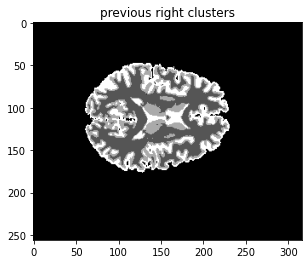

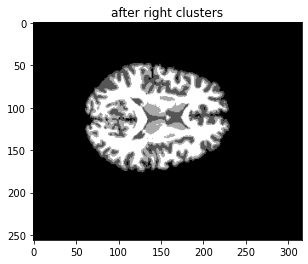

Final time:  205.09949040412903


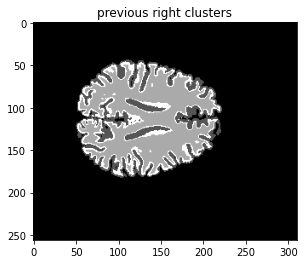

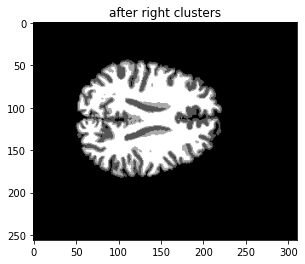

Final time:  250.2889688014984


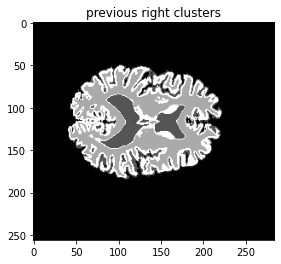

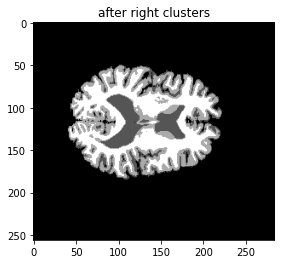

Convergence achieved before ending iterations!
Final time:  117.96585965156555


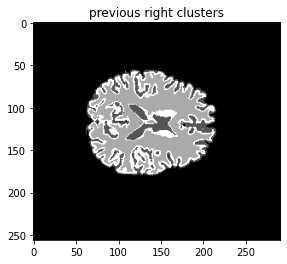

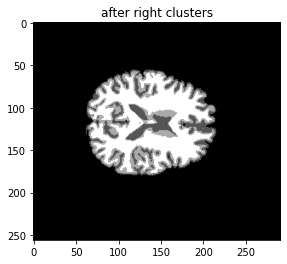

Final time:  191.41219902038574


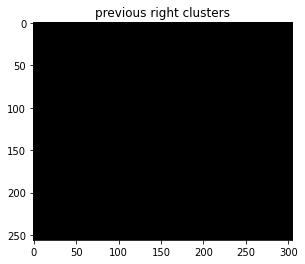

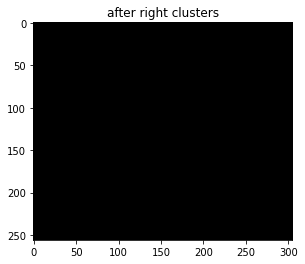

Final time:  193.27269625663757


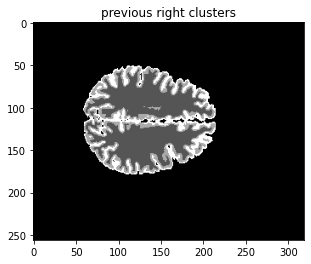

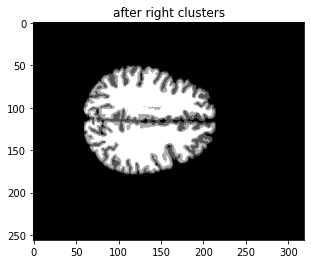

Final time:  210.32489681243896


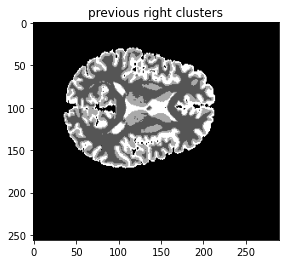

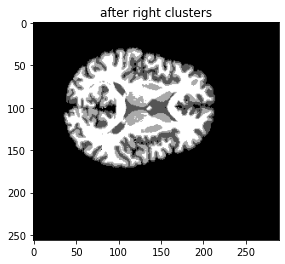

Final time:  243.82549667358398


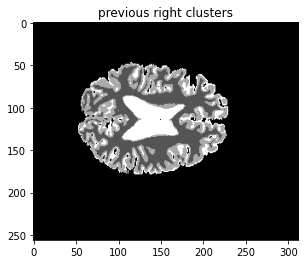

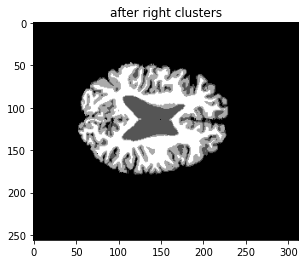

Convergence achieved before ending iterations!
Final time:  169.89433217048645


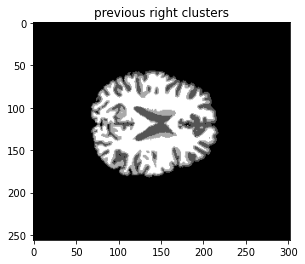

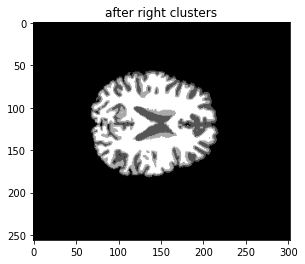

Final time:  190.93478226661682


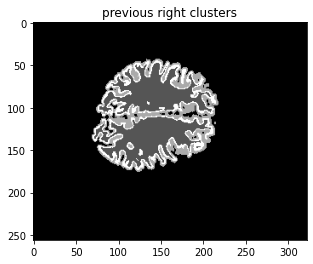

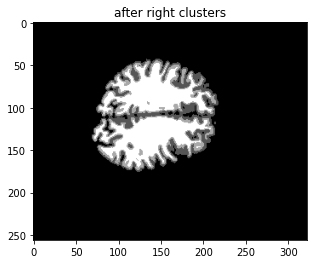

Final time:  193.47125840187073


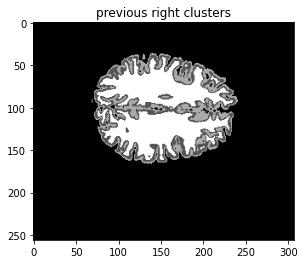

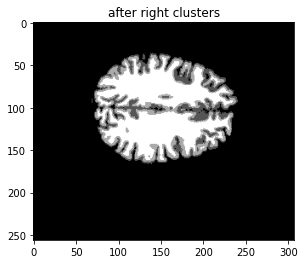

Final time:  241.45148396492004


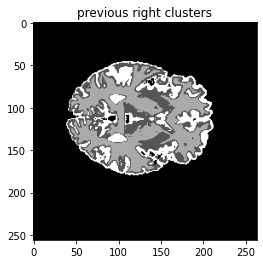

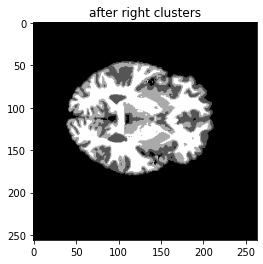

Final time:  226.6079592704773


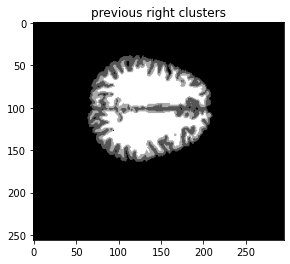

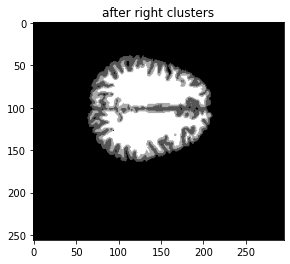

Final time:  182.95481324195862


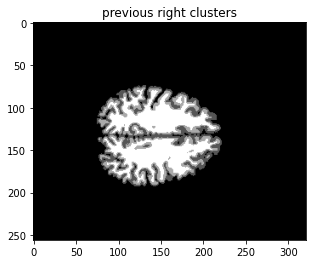

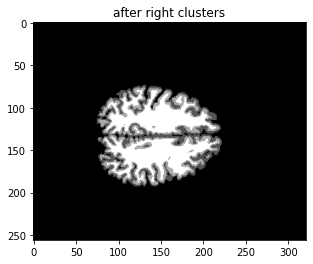

Final time:  201.5898461341858


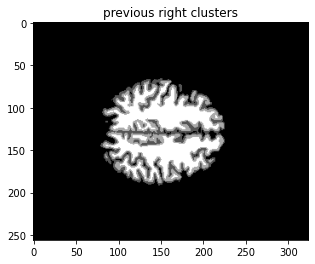

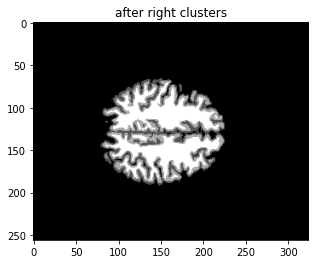

Final time:  214.95316791534424


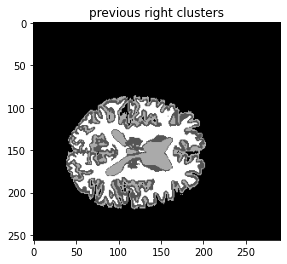

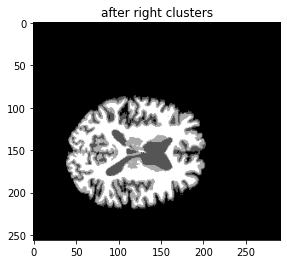

Final time:  232.7587730884552


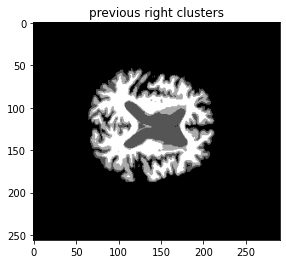

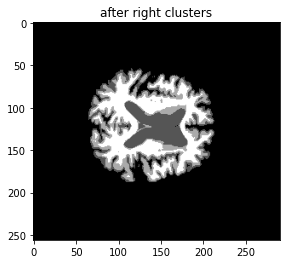

Final time:  209.74276185035706


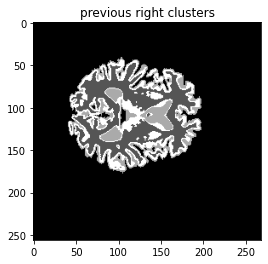

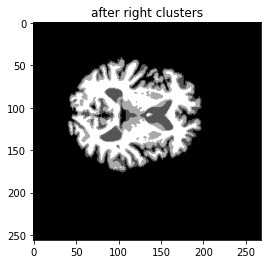

Final time:  182.62388491630554


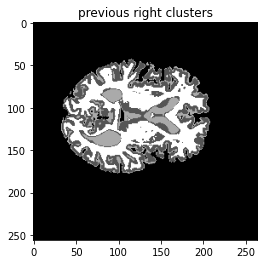

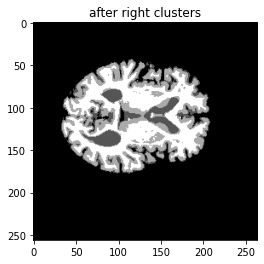

Convergence achieved before ending iterations!
Final time:  174.06496691703796


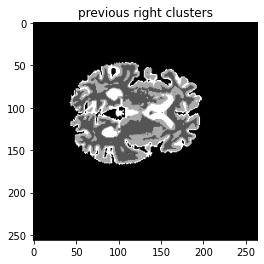

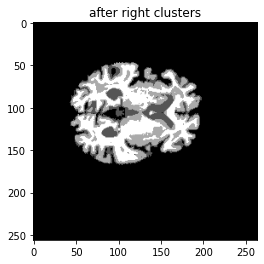

Final time:  168.55570602416992


In [ ]:
RESULTS_DIR = "/content/drive/MyDrive/MAIA/Semester3/MISA/Lab3" 
FOLDER_DIR = "/content/drive/MyDrive/MAIA/Semester3/MISA/Lab3/test-set"

patients = os.listdir(os.path.join(FOLDER_DIR, 'testing-images'))
groundtruths = os.listdir(os.path.join(FOLDER_DIR, 'testing-labels'))

patients.sort()
groundtruths.sort()

# clusters
clusters = 3

# iterations
iterations = 500

# dimensions
dim = 1

#patients = ["1018.nii.gz"]
#groundtruths = ["1018_3C.nii.gz"]

# # import data
for patient, groundtruth in zip(patients, groundtruths):

  img = nib.load(os.path.join(FOLDER_DIR, "testing-images", patient)).get_fdata()
  img_info = nib.load(os.path.join(FOLDER_DIR, "testing-images", patient))
  #print(img_info.affine)

  gt = nib.load(os.path.join(FOLDER_DIR, "testing-labels", groundtruth)).get_fdata()

  # normalisation step
  img = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

  # skull stripping with the groundtruth mask
  brain_t1 = img[gt > 0]

  # brain vector of intensities
  vector_brain = brain_t1.reshape(-1)

  # get kmeans to extract initialisation parameters
  kmeans, labels = segmentation_kmeans(vector_brain, 3)

  # initialising variable of kmeans labels
  reshape_kmeans = np.zeros(img.shape)

  # indexes of voxels that are part of the brain
  m = np.where(gt != 0)

  count = 0
  for i, j, k in zip(m[0], m[1], m[2]):
      # reconstruction of labels
      reshape_kmeans[i, j, k] = labels[count] + 1
      count += 1

  #print(np.unique(reshape_kmeans))

  # fit right clusters to compare to the grountruth
  reshape_kmeans = get_right_cluster(gt, reshape_kmeans, img)
  #print('after grc ',  np.unique(reshape_kmeans))

  reshape_kmeans = reshape_kmeans[gt > 0]

  # get csf, wm and gm
  csf_t1, wm_t1, gm_t1 =  get_vector_image(reshape_kmeans, brain_t1)

  # mean and std of csf, wm, gm
  mean_csf, std_csf = init_mean_cov(csf_t1) # mean 2x1, std 2x2
  mean_wm, std_wm = init_mean_cov(wm_t1) 
  mean_gm, std_gm = init_mean_cov(gm_t1)

  # initial mu 2x3 and std (2x2)x3
  mu = np.hstack((mean_csf, mean_wm, mean_gm))
  std = np.hstack((std_csf, std_wm, std_gm))

  # x array of pixels values for both dimensions
  x = np.array([brain_t1]) # xi . 1x(all brain pixels)

  # initial alpha 
  alpha = np.array([1/3,1/3,1/3])

  # initial weights matrix
  weights = np.zeros((x.shape[1], clusters), dtype=np.float32)

  # COMPUTE LOGLIKELIHOOD

  # membership matrix variables
  # library so fast, 1 second per epoch
  #print(np.isnan(x).any())
  #print(np.isinf(x).any())
  #print(mu)
  #print(std)
  p_gauss, dif = prior_probs_lib(x, clusters, mu, std)

  # our 30s per epoch
  #p_gauss, dif = prior_probs(x, k, mu, std, dim)

  # initial loglikelihood
  log_likelihood = -100

  # executing of algorithm
  weights = emalgorithm(iterations, p_gauss, x, mu, std, alpha, clusters, log_likelihood)

  # Reconstruct the Brain 
  m = np.where(gt != 0)
  em = np.zeros(img.shape)
  count = 0

  for i, j, k in zip(m[0], m[1], m[2]):
      # reconstruction of labels
      em[i, j, k] = np.argmax(weights[count, :]) + 1
      count += 1

  data = np.ones(img.shape, dtype=np.int16)
  img_new = nib.Nifti1Image(em, img_info.affine)
  img_new.get_data_dtype() == np.dtype(np.int16)

  nib.save(img_new, os.path.join(RESULTS_DIR, 'EMResults-kmeans', patient.split('.')[0]+'_kmeans.nii.gz')) 

In [ ]:


#csf_knumber, gm_knumber, wm_knumber
dice_csf = compute_dice_coefficient(gt == 1, em == 2)
dice_gm =  compute_dice_coefficient(gt == 2, em == 3)
dice_wm = compute_dice_coefficient(gt == 3, em == 1)

print(dice_csf)
print(dice_gm)
print(dice_wm)
